In [2]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# **Read CSV file and choose 'Date" as index**

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MSFT_historical_data_yfinance.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2013-12-13,31.509763,31.535026,30.836118,30.895061,40066100
2013-12-16,30.928732,31.156088,30.768743,31.063461,31734200
2013-12-17,31.105562,31.248713,30.591910,30.751900,45687700
2013-12-18,30.617180,30.819271,29.918271,30.802433,63192100
2013-12-19,30.743483,30.777166,30.381401,30.524549,34160100
...,...,...,...,...,...
2023-12-07,368.230011,371.450012,366.320007,370.950012,23118900
2023-12-08,369.200012,374.459991,368.230011,374.230011,20144800
2023-12-11,368.480011,371.600006,366.100006,371.299988,27708800


# **Visualize the close prices with graphs**

<function matplotlib.pyplot.show(close=None, block=None)>

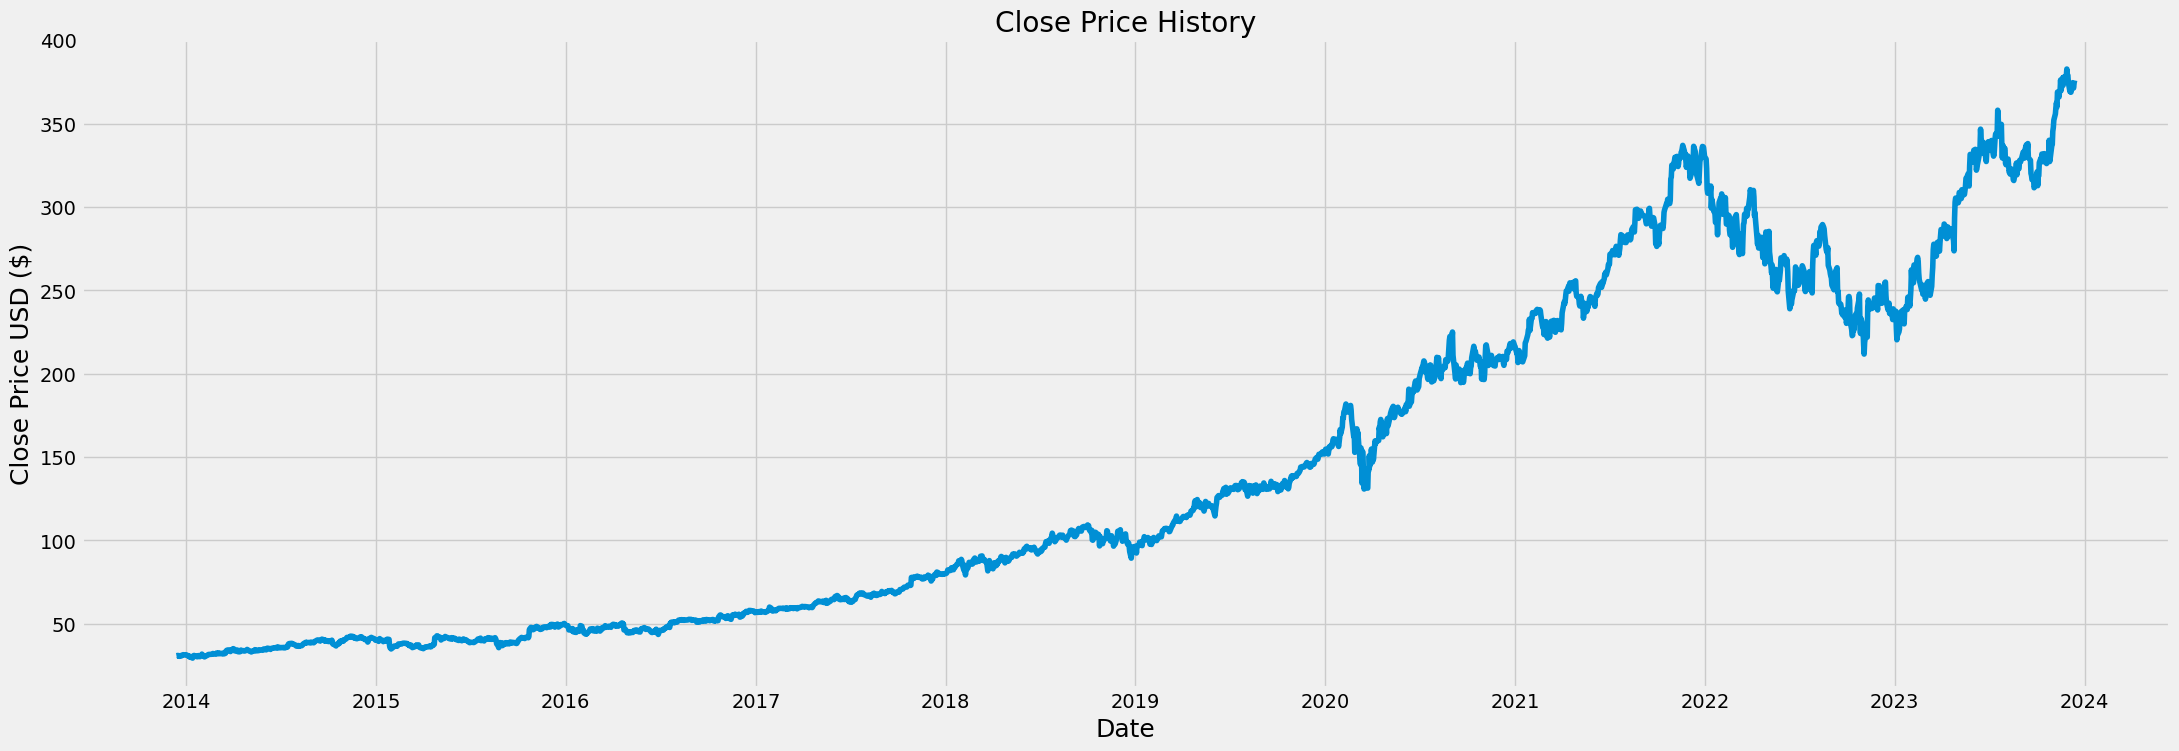

In [6]:
plt.figure(figsize = (24,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show

# **Data processing**

In [7]:
# Create a new data frame with only "Close" column
data = df.filter(['Close'])
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*0.8795)

In [8]:
# Scale the data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00407628],
       [0.00455301],
       [0.00367101],
       ...,
       [0.9677277 ],
       [0.97644691],
       [0.98069378]])

In [9]:
# Create the training dataset
# Create the scaled training dataset
train_data = scaled_data[0:training_data_len, :]
# Split the data into x-train and y-train dataset
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [10]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2154, 60, 1)

In [12]:
# Create the validation set
x_val = []
y_val = []
for i in range(training_data_len, len(scaled_data)-52):
    x_val.append(scaled_data[i-60:i, 0])
    y_val.append(scaled_data[i, 0])

# Convert the x_val and y_val to numpy arrays
x_val, y_val = np.array(x_val), np.array(y_val)

# Reshape the validation data
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# **Build and train LSTM model**

In [17]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1))) # Add an LSTM layer with 50 units
model.add(LSTM(50, return_sequences = False)) # Add another LSTM layer, which is output layer
model.add(Dense(25)) # Add a fully-connected layer for learning non-linear mappings
model.add(Dense(1)) #Add an output layer with 1 unit

In [18]:
# Compile the model
model.compile(optimizer ='adam', loss = 'mean_squared_error')

In [24]:
# Train the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=30, epochs=50)

Epoch 1/50
72/72 [==============================] - 8s 104ms/step - loss: 2.9083e-04 - val_loss: 6.4302e-04
Epoch 2/50
72/72 [==============================] - 4s 58ms/step - loss: 2.5631e-04 - val_loss: 6.7429e-04
Epoch 3/50
72/72 [==============================] - 5s 69ms/step - loss: 2.2093e-04 - val_loss: 6.3826e-04
Epoch 4/50
72/72 [==============================] - 6s 83ms/step - loss: 2.3444e-04 - val_loss: 7.5242e-04
Epoch 5/50
72/72 [==============================] - 4s 60ms/step - loss: 2.0670e-04 - val_loss: 5.6648e-04
Epoch 6/50
72/72 [==============================] - 4s 61ms/step - loss: 2.2953e-04 - val_loss: 6.0057e-04
Epoch 7/50
72/72 [==============================] - 6s 90ms/step - loss: 2.0427e-04 - val_loss: 5.3181e-04
Epoch 8/50
72/72 [==============================] - 4s 56ms/step - loss: 1.8545e-04 - val_loss: 5.3333e-04
Epoch 9/50
72/72 [==============================] - 5s 66ms/step - loss: 1.8563e-04 - val_loss: 8.8120e-04
Epoch 10/50
72/72 [=================

In [25]:
# Create the testing data set
# Create a new array containing scaled values from index 2013 to 2591
test_data = scaled_data[training_data_len + 191 : , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len + 251 : , :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])
# Convert the data to a numpy array
x_test = np.array(x_test)

In [26]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1))

In [27]:
# Get the model predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 0s 20ms/step


In [28]:
# Get the root mean square error (RMSE)
rmse = np.sqrt(np.mean((predictions - y_test)**2))
rmse

5.599137094796368

In [29]:
# Predict on validation set
y_val_predict = model.predict(x_val)
y_val_predict = scaler.inverse_transform(y_val_predict)

8/8 [==============================] - 0s 18ms/step


<ipython-input-30-f279c75728a7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid ['Predictions'] = y_val_predict


<function matplotlib.pyplot.show(close=None, block=None)>

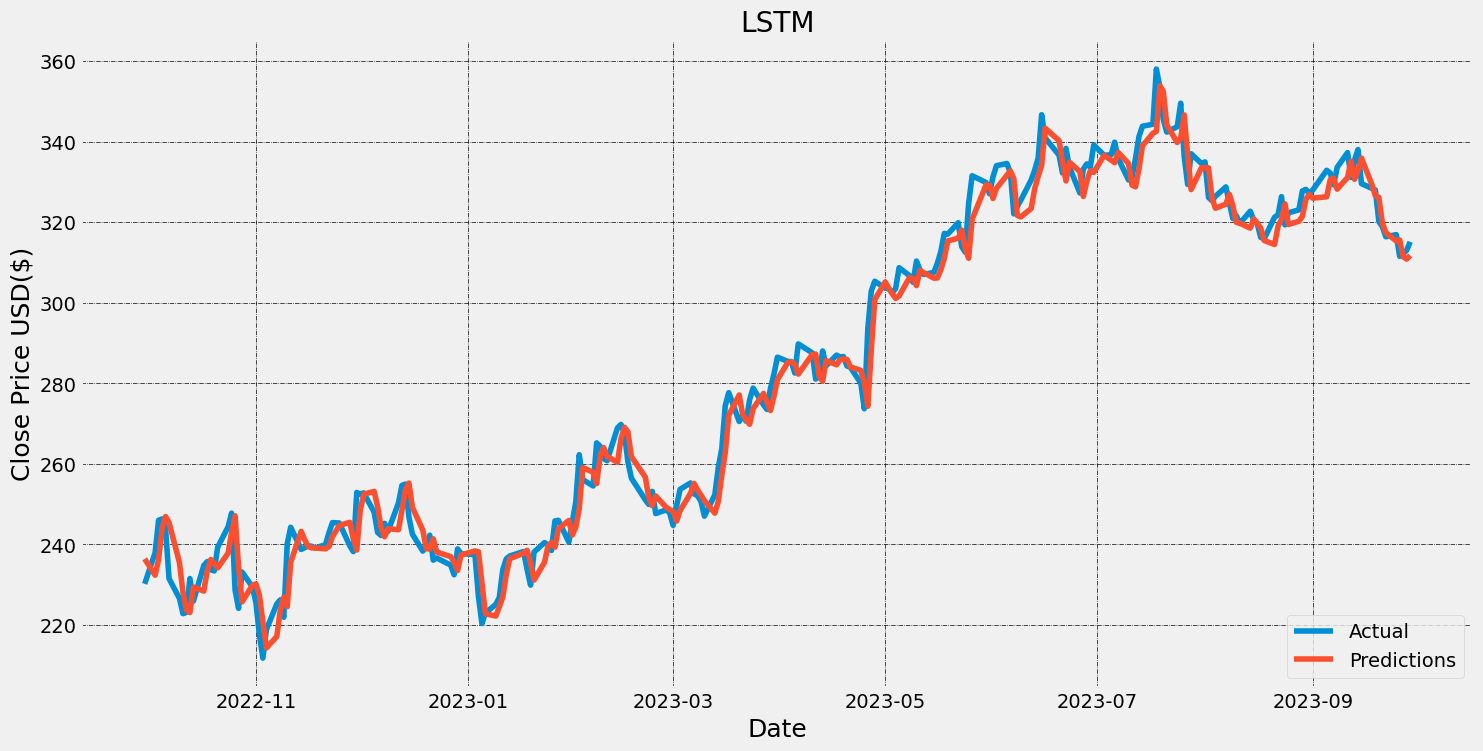

In [30]:
# Compare the prediction with the actual with graph
train = data[:training_data_len]
valid = data[training_data_len:-52]
valid ['Predictions'] = y_val_predict
#visualize the data
plt.figure(figsize = (16,8))
plt.title('LSTM')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD($)', fontsize = 18)
# plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.grid(which='major',color='k', linestyle='-.',linewidth=0.5)
plt.legend(['Actual', 'Predictions'], loc = 'lower right')
plt.show

In [32]:
#Compare the prediction and the actual with Dataframe
valid

,Close,Predictions
Date,,
2022-09-30,230.204285,236.408783
2022-10-03,237.953552,232.359665
2022-10-04,245.999344,236.246933
2022-10-05,246.315613,243.983597
2022-10-06,243.933533,246.923523
...,...,...
2023-09-25,316.896820,315.329529
2023-09-26,311.507751,315.557373
2023-09-27,312.156433,311.378784


# **Evaluation**

In [31]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# Get predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculate R-squared and explained variance
y_true = y_test
y_pred = predictions
explained_variance = r2_score(y_true, y_pred)
test_r_squared = explained_variance
test_explain_variation = explained_variance * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
test_mape = mape * 100

# Calculate other metrics (optional)
test_mae = mean_absolute_error(y_true, y_pred)
test_mse = mean_squared_error(y_true, y_pred)
test_rmse = np.sqrt(test_mse)

# Print test metrics
print(f"Test R-squared: {test_r_squared}")
print(f"Test MAPE: {test_mape}%")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")


2/2 [==============================] - 0s 17ms/step
Test R-squared: 0.934354193732796
Test MAPE: 1.3206225694267897%
Test MSE: 31.350336206324712
Test RMSE: 5.599137094796368
Test MAE: 4.62790738619291
